<a href="https://colab.research.google.com/github/Thejasvenan/EN3150_A03_Vision/blob/main/PR_with_imageprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
dataset_path = "rice_leaf_diseases"


import kagglehub

# Download latest dataset
path = kagglehub.dataset_download("vbookshelf/rice-leaf-diseases")
print("Path to dataset files:", path)

# Dataset root folder
updated_path = os.path.join(path, 'rice_leaf_diseases')
print(os.listdir(updated_path))

# Class folders
Leaf_smut = os.path.join(updated_path, 'Leaf smut')
leaf_blight = os.path.join(updated_path, 'Bacterial leaf blight')
Brown_spot = os.path.join(updated_path, 'Brown spot')

# Check sample files
print("Leaf smut files:", os.listdir(Leaf_smut)[:5])
print("Leaf blight files:", os.listdir(leaf_blight)[:5])
print("Brown spot files:", os.listdir(Brown_spot)[:5])

100%|██████████| 36.7M/36.7M [00:01<00:00, 25.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vbookshelf/rice-leaf-diseases/versions/1
['Leaf smut', 'Bacterial leaf blight', 'Brown spot']
Leaf smut files: ['DSC_0312.JPG', 'DSC_0505.jpg', 'DSC_0313.JPG', 'DSC_0330.jpg', 'DSC_0317.JPG']
Leaf blight files: ['DSC_0384.JPG', 'DSC_0392.JPG', 'DSC_0373.JPG', 'DSC_0406.JPG', 'DSC_0365.JPG']
Brown spot files: ['DSC_0323.JPG', 'DSC_0106.jpg', 'DSC_0100.jpg', 'DSC_0304.JPG', 'DSC_0113.jpg']


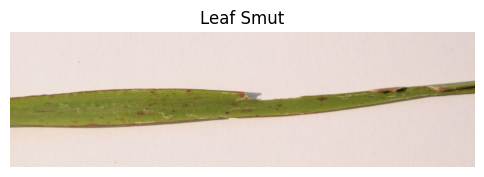

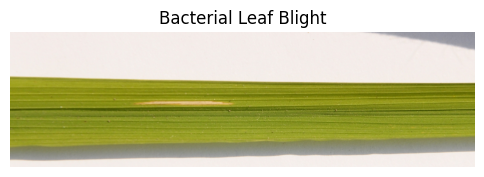

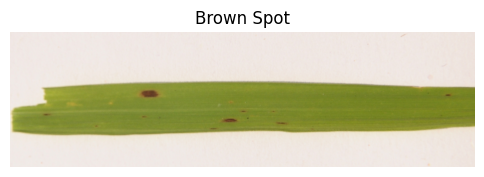

In [ ]:
i = 20

Leaf_smut_1 = Image.open(os.path.join(Leaf_smut, os.listdir(Leaf_smut)[i]))
plt.figure(figsize=(6,6))
plt.imshow(Leaf_smut_1)
plt.axis('off')
plt.title("Leaf Smut")
plt.show()

leaf_blight_1 = Image.open(os.path.join(leaf_blight, os.listdir(leaf_blight)[i]))
plt.figure(figsize=(6,6))
plt.imshow(leaf_blight_1)
plt.axis('off')
plt.title("Bacterial Leaf Blight")
plt.show()

Brown_spot_1 = Image.open(os.path.join(Brown_spot, os.listdir(Brown_spot)[i]))
plt.figure(figsize=(6,6))
plt.imshow(Brown_spot_1)
plt.axis('off')
plt.title("Brown Spot")
classes = ["Leaf smut", "Bacterial leaf blight", "Brown spot"]

In [ ]:

output_base = "dataset_split"

for folder in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(output_base, folder, cls), exist_ok=True)

def split_and_copy(class_folder, class_name, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    files = os.listdir(class_folder)
    random.shuffle(files)
    n = len(files)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)
    for f in files[:n_train]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "train", class_name, f))
    for f in files[n_train:n_train+n_val]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "val", class_name, f))
    for f in files[n_train+n_val:]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "test", class_name, f))

for cls in classes:
    split_and_copy(os.path.join(updated_path, cls), cls)

In [ ]:
def preprocess_leaf_image(img_path, output_size=(128,128), clahe_clip=2.0, clahe_grid=(8,8)):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # CLAHE enhancement in LAB space
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=clahe_grid)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    # Grayscale for thresholding
    gray = cv2.cvtColor(img_clahe, cv2.COLOR_RGB2GRAY)

    # Threshold to detect dark spots
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        roi = img_clahe
    else:
        x_min = min([cv2.boundingRect(c)[0] for c in contours])
        y_min = min([cv2.boundingRect(c)[1] for c in contours])
        x_max = max([cv2.boundingRect(c)[0]+cv2.boundingRect(c)[2] for c in contours])
        y_max = max([cv2.boundingRect(c)[1]+cv2.boundingRect(c)[3] for c in contours])
        roi = img_clahe[y_min:y_max, x_min:x_max]

    roi_resized = cv2.resize(roi, output_size, interpolation=cv2.INTER_CUBIC)
    roi_normalized = roi_resized / 255.0
    return roi_normalized

In [ ]:


def load_dataset(folder_path, classes, img_size=(128,128)):
    X = []
    y = []
    for idx, cls in enumerate(classes):
        cls_folder = os.path.join(folder_path, cls)
        for f in os.listdir(cls_folder):
            img_path = os.path.join(cls_folder, f) # This needs to be constructed using the output_base
            try:
                img = preprocess_leaf_image(img_path, output_size=img_size)
                X.append(img)
                y.append(idx)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
                continue
    X = np.array(X)
    y = np.array(y)
    y = tf.keras.utils.to_categorical(y, num_classes=len(classes))
    return X, y

X_train, y_train = load_dataset(os.path.join(output_base, "train"), classes)
X_val, y_val = load_dataset(os.path.join(output_base, "val"), classes)
X_test, y_test = load_dataset(os.path.join(output_base, "test"), classes)

In [ ]:
def build_simple_cnn(input_shape=(128,128,3), num_classes=3, dropout_rate=0.5):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

model = build_simple_cnn(input_shape=(128,128,3), num_classes=len(classes))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,307,395 (16.43 MB)

 Trainable params: 4,307,395 (16.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=10)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 577ms/step - accuracy: 0.4575 - loss: 1.1002 - val_accuracy: 0.3333 - val_loss: 1.1040
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 516ms/step - accuracy: 0.3346 - loss: 1.0968 - val_accuracy: 0.3333 - val_loss: 1.0871
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 682ms/step - accuracy: 0.3585 - loss: 1.0902 - val_accuracy: 0.3889 - val_loss: 1.0662
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 583ms/step - accuracy: 0.3093 - loss: 1.1004 - val_accuracy: 0.6111 - val_loss: 1.0447
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 561ms/step - accuracy: 0.4456 - loss: 1.0544 - val_accuracy: 0.5000 - val_loss: 1.0062
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 683ms/step - accuracy: 0.5847 - loss: 0.9797 - val_accuracy: 0.6667 - val_loss: 0.9543
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 675ms/step - accuracy: 0.5889 - loss: 0.9456 - val_accuracy: 0.7222 - val_loss: 0.8853
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - accuracy: 0.7732 - loss: 0.8293 - val_accuracy: 0.6667 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.5556 - loss: 0.7433
Test Accuracy: 55.56%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


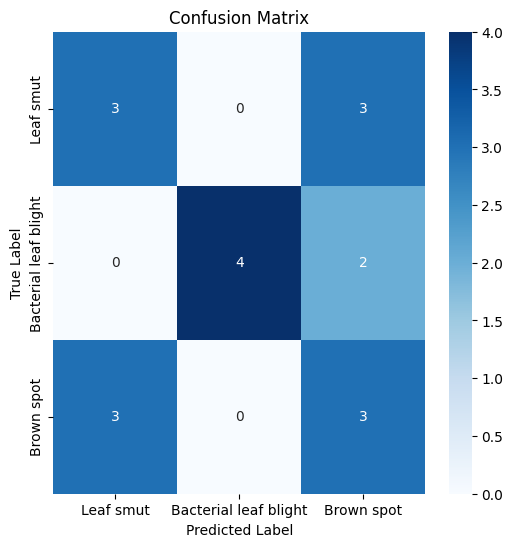

                       precision    recall  f1-score   support

            Leaf smut       0.50      0.50      0.50         6
Bacterial leaf blight       1.00      0.67      0.80         6
           Brown spot       0.38      0.50      0.43         6

             accuracy                           0.56        18
            macro avg       0.62      0.56      0.58        18
         weighted avg       0.62      0.56      0.58        18



In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes,
            yticklabels=classes, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

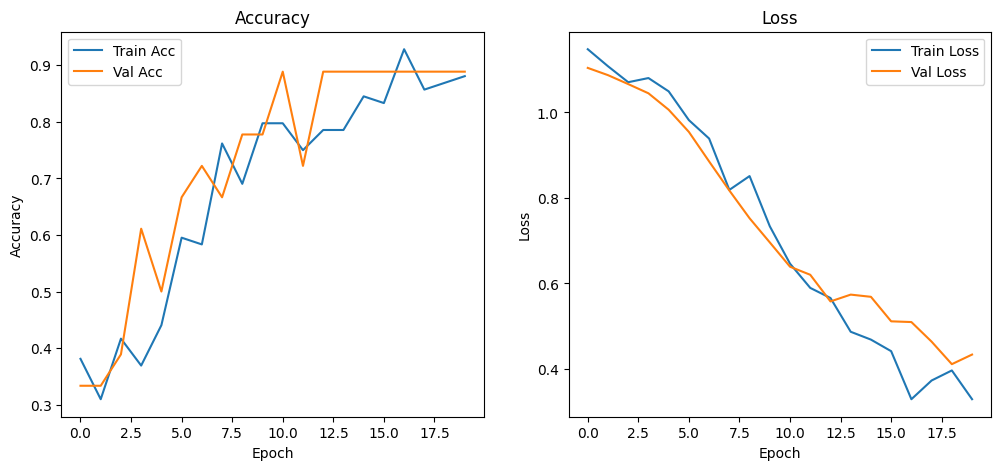

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()